<h1>Card recognition</h1>

<p style="font-size:18px;">
This project implements a card recognition system using algorithms and image processing techniques. The system processes images of playing cards to identify their values and suits.
</p>

<h3>Project: Giuseppe Adduce</h3>


## 1. Import Libraries and Define Main Parameters

In this first cell import the necessary libraries for the project.

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

## 2. Load the Image and Apply Edge Detection

In this step, load the card image and convert it to grayscale. Grayscale simplifies edge detection by reducing complexity and color information.
- **Edge Detection**: Apply the Canny edge detection algorithm to highlight the card's features. This technique isolates the shapes within the card image, which will later be compared against template shapes.

This process is essential as it prepares the image, making symbols within the card more detectable.

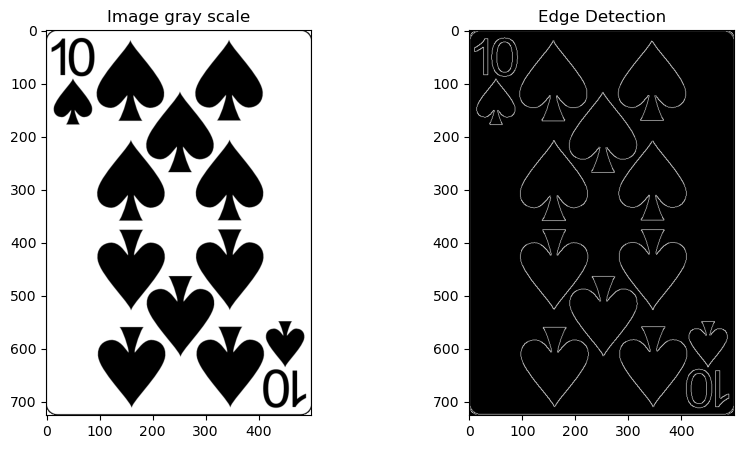

In [3]:
def load_and_detect_edges(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_edges = cv2.Canny(img, 50, 150)
    img_color = cv2.imread(img_path)  # Per visualizzare a colori

    # Visualizza i risultati
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Image gray scale')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_edges, cmap='gray')
    plt.title('Edge Detection')
    plt.show()
    
    return img_edges, img_color

img_edges, img_color = load_and_detect_edges('images/cards/10_of_spades.png')


## 3. Process Template Images

Load and prepare each template image (representing different card symbols) from a specified folder.
- **Template Preparation**: Each template image is loaded and processed through edge detection, similar to the card image, to highlight symbol contours.
- **Rotation**: A rotated version of each template (rotated 180 degrees) is created. This allows the system to detect symbols regardless of their orientation in the card image.

This step prepares a collection of symbol templates for accurate comparison against the card image.

In [4]:
def process_templates(templates_folder):
    templates = {}
    for template_name in os.listdir(templates_folder):
        template_path = os.path.join(templates_folder, template_name)
        template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
        
        if template is not None:
            template_edges = cv2.Canny(template, 50, 150)
            template_rotated = cv2.rotate(template_edges, cv2.ROTATE_180)
            templates[template_name] = (template_edges, template_rotated)
    
    print("Templates processati:", list(templates.keys()))
    return templates

templates = process_templates('images/templates/')


Templates processati: ['QUADRI.jpg', 'JACK_CUORI.jpg', 'ASSO_FIORI.jpg', 'FIORI.jpg', 'PICCHE.jpg', 'FIORE_REGINA_CUORI.jpg', 'CUORE.jpg', 'RE_CUORI.jpg', 'ASSO_CUORI.jpg', 'RE_QUADRI.jpg', 'JACK_FIORI.jpg', 'FIORE_REGINA_PICCHE.jpg', 'JACK_QUADRI.jpg', 'ASSO_QUADRI.jpg', 'FIORE_REGINA_QUADRI.jpg', 'FIORE_REGINA_FIORI.jpg', 'RE_PICCHE.jpg', 'JACK_PICCHE.jpg', 'RE_FIORI.jpg', 'ASSO_PICCHE.jpg']


## 4. Template Matching

With the prepared card image and templates, now apply template matching.
- **Template Matching**: This technique slides each template across the card image to find locations where the template matches with high accuracy.
- **Position Collection**: Positions that meet a specified similarity threshold are recorded. These positions represent potential matches for symbols on the card.

The purpose of this step is to identify where symbols similar to the templates appear on the card, storing each matching location for further analysis.

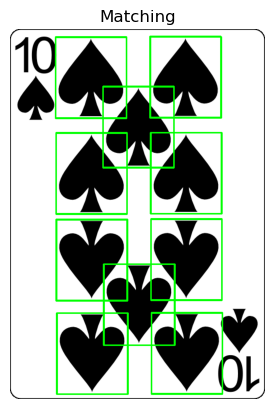

In [5]:
def match_templates(img_edges, img_color, templates, threshold=0.5):
    positions = {}
    for template_name, (template_edges, template_rotated) in templates.items():
        temp_positions = []
        for temp in [template_edges, template_rotated]:
            w, h = temp.shape[::-1]
            res = cv2.matchTemplate(img_edges, temp, cv2.TM_CCOEFF_NORMED)
            loc = np.where(res >= threshold)
            for pt in zip(*loc[::-1]):
                temp_positions.append(pt)
                cv2.rectangle(img_color, pt, (pt[0] + w, pt[1] + h), (0, 255, 0), 2)
        positions[template_name] = temp_positions
    
    plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
    plt.title("Matching")
    plt.axis('off')
    plt.show()
    
    return positions

positions = match_templates(img_edges, img_color, templates)


## 5. Cluster Detected Symbols Using DBSCAN

Since multiple instances of the same symbol can appear on a card, we need to group them to count unique occurrences.
- **Clustering with DBSCAN**: DBSCAN, a density-based clustering algorithm, is applied to the matched positions. This groups symbols that are close together spatially, interpreting them as a single occurrence.
- **Counting Unique Symbols**: For each template, the number of clusters is counted. This count represents the unique symbols on the card.

Clustering helps accurately determine the number of each symbol type, avoiding double-counting overlapping matches.

In [8]:
def cluster_positions(positions, min_distance=30):
    max_count = 0
    best_template_name = None
    for template_name, temp_positions in positions.items():
        if temp_positions:
            positions_array = np.array(temp_positions)
            clustering = DBSCAN(eps=min_distance, min_samples=1).fit(positions_array)
            num_symbols = len(set(clustering.labels_))
            
            if num_symbols > max_count:
                max_count = num_symbols
                best_template_name = template_name
    
    print(f"Best template: {best_template_name}, Number of symobls: {max_count}")
    return best_template_name, max_count

best_template_name, max_count = cluster_positions(positions)



Best template: PICCHE.jpg, Number of symobls: 10


## 6. Final Identification and Card Recognition

### Key Steps:

1. **Mapping Template Names**: A dictionary (`symbol_map`) maps template filenames to readable card descriptions, identifying the type of symbol detected.

2. **Determine and Print Card Value**: Based on the number of detected symbols, the function constructs a card description (e.g., "10 of hearts") and prints it.

3. **Display Processed Card Image**: The processed card image, with rectangles around detected symbols, is displayed using Matplotlib.

4. **Display Template Image**: The matched template image is shown next to the processed card, allowing a side-by-side comparison of the recognized symbol and the template used.

This side-by-side visualization aids in validating the matching accuracy and the overall recognition result.

La carta è: 10 di picche / of spades


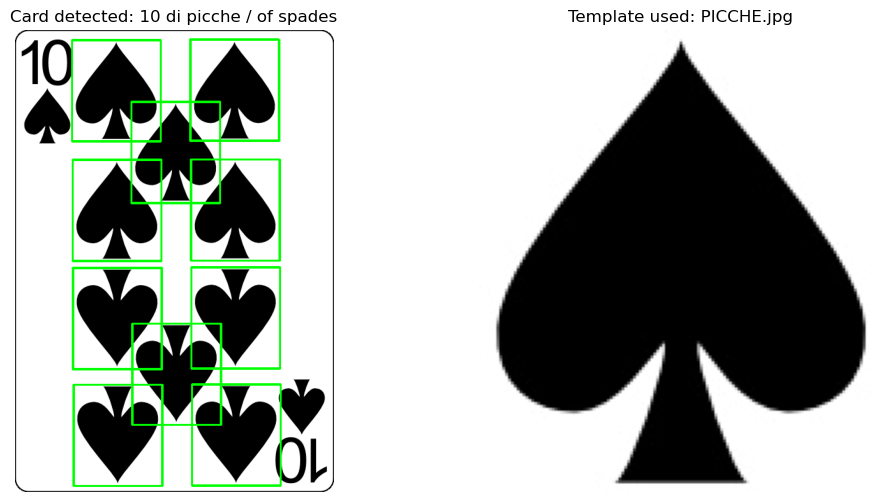

'10 di picche / of spades'

In [9]:
templates_folder = 'images/templates/'  
def recognize_card(template_name, max_count, img_color, templates_folder):
    # Mappatura dei template con i nomi leggibili
    symbol_map = {
        "CUORE.jpg": "di cuori / of hearts",
        "FIORI.jpg": "di fiori / of clubs",
        "PICCHE.jpg": "di picche / of spades",
        "QUADRI.jpg": "di quadri / of diamonds",
        "FIORE_REGINA_CUORI.jpg": "Regina di cuori / Queen of hearts",
        "FIORE_REGINA_FIORI.jpg": "Regina di fiori / Queen of clubs",
        "FIORE_REGINA_PICCHE.jpg": "Regina di picche / Queen of spades",
        "FIORE_REGINA_QUADRI.jpg": "Regina di quadri / Queen of diamonds",
        "JACK_QUADRI.jpg": "Jack di quadri / Jack of diamonds",
        "JACK_PICCHE.jpg": "Jack di picche / Jack of spades",
        "JACK_FIORI.jpg": "Jack di fiori / Jack of clubs",
        "JACK_CUORI.jpg": "Jack di cuori / Jack of hearts",
        "RE_CUORI.jpg": "Re di cuori / King of hearts",
        "RE_QUADRI.jpg": "Re di quadri / King of diamonds",
        "RE_PICCHE.jpg": "Re di picche / King of spades",
        "RE_FIORI.jpg": "Re di fiori / King of clubs",
        "ASSO_CUORI.jpg": "Asso di cuori / ACE of hearts",
        "ASSO_QUADRI.jpg": "Asso di quadri / ACE of diamonds",
        "ASSO_PICCHE.jpg": "Asso di picche / ACE of spades",
        "ASSO_FIORI.jpg": "Asso di fiori / ACE of clubs",
    }
    
    # Recupera il simbolo rilevato
    detected_symbol = symbol_map.get(template_name, "Nessun simbolo rilevato")
    # Determina il valore della carta in base al numero di simboli trovati
    card_value = f"{max_count} {detected_symbol}" if detected_symbol else "Nessun simbolo rilevato"
    # Determines the value of the card based on the detected symbol and count
    if detected_symbol and any(x in detected_symbol for x in ["King", "Jack", "Queen", "ACE"]):
        card_value = detected_symbol
    else:
        card_value = f"{max_count} {detected_symbol}" if detected_symbol else "Nessun simbolo rilevato"
    
    # Stampa il risultato
    print(f"La carta è: {card_value}")
    
    # Carica e visualizza il template usato
    template_path = os.path.join(templates_folder, template_name)
    template_img = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
    
    # Converte img_color in RGB per visualizzazione
    img_color_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
    
    # Visualizza la carta con simboli trovati e il template usato
    plt.figure(figsize=(12, 6))
    
    # Carta processata con simboli trovati
    plt.subplot(1, 2, 1)
    plt.imshow(img_color_rgb)
    plt.axis('off')
    plt.title(f"Card detected: {card_value}")
    
    # Template usato per il riconoscimento
    plt.subplot(1, 2, 2)
    plt.imshow(template_img, cmap='gray')
    plt.axis('off')
    plt.title(f"Template used: {template_name}")
    
    plt.show()
    
    return card_value

# Richiama la funzione con i valori ottenuti e l'immagine a colori
recognize_card(best_template_name, max_count, img_color, templates_folder)


This project is an alternative to the first, instead of making a manual insertion. I created a drop-down menu that gives the possibility to choose the card directly

<h1>Assignment 07 - Card Recognition</h1>

<p style="font-size:18px;">
I developed a function called <code>recognize_card</code> to identify playing cards based on the symbols present on them. Here are the main steps I followed:
</p>

<ol style="font-size:18px;">
    <li><b>Loading and Preprocessing</b>: I loaded the card image in grayscale and applied edge detection using the Canny algorithm. I also created a color copy to add annotations for the detected symbols.</li>
    <li><b>Template Scanning</b>: I scanned the template files in the specified folder and applied edge detection to each template, including a 180° rotated version.</li>
    <li><b>Template Matching</b>: I used <code>cv2.matchTemplate</code> to compare the card edges with those of the templates, storing the positions of detected symbols in a temporary list.</li>
    <li><b>Clustering with DBSCAN</b>: I used DBSCAN to group the symbols based on a minimum distance, identifying unique symbols.</li>
    <li><b>Symbol Counting</b>: I compared the number of symbols found for each template, updating the best match if a template had more symbols than previous ones.</li>
    <li><b>Mapping and Recognition</b>: I used a symbol map to translate the best-matching template into a readable description, such as “of hearts” or “Queen of diamonds.”</li>
    <li><b>Visualization and Output</b>: I added the symbol count to the image and displayed the result with Matplotlib, concluding with a printout of the card description.</li>
</ol>

<p style="font-size:18px;">
I also created an interactive interface with <code>ipywidgets</code> to allow image selection and dynamic execution of the <code>recognize_card</code> function.
</p>


In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from ipywidgets import interact
from IPython.display import display

def recognize_card(img_path, templates_folder, threshold=0.5, min_distance=30):
    # Load the card to analyze and apply edge detection
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_edges = cv2.Canny(img, 50, 150)  # Applica il rilevamento dei bordi
    img_color = cv2.imread(img_path)  # Copia a colori per la visualizzazione
    positions = []  # Lista delle posizioni dei simboli trovati
    best_template_name = None
    max_count = 0  # Variabile per conservare il conteggio massimo di simboli trovati
    
    # Scroll all template files in the specified folder
    for file_name in os.listdir(templates_folder):
        template_path = os.path.join(templates_folder, file_name)
        template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
        
        if template is None:
            continue
        
         # Apply edge detection to the template
        template_edges = cv2.Canny(template, 50, 150)
        
         # Template 180°
        template_rotated = cv2.rotate(template_edges, cv2.ROTATE_180)
        
        # Matching with original template and rotate template
        temp_positions = []  # Posizioni per il template corrente
        for temp in [template_edges, template_rotated]:
            # Ottieni le dimensioni del template
            w, h = temp.shape[::-1]
            
            # Template matching on the edges
            res = cv2.matchTemplate(img_edges, temp, cv2.TM_CCOEFF_NORMED)
            
            # Find all positions that exceed the threshold
            loc = np.where(res >= threshold)
            
            for pt in zip(*loc[::-1]):
                temp_positions.append(pt)  # Aggiungi la posizione del simbolo trovata
                cv2.rectangle(img_color, pt, (pt[0] + w, pt[1] + h), (0, 255, 0), 2)
        
        # Apply DBSCAN at the end of the loop for the current model
        if temp_positions:
            # Convert position in array NumPy for clustering
            positions_array = np.array(temp_positions)
            clustering = DBSCAN(eps=min_distance, min_samples=1).fit(positions_array)
            
            # Count the number of clusters found for this template
            num_symbols = len(set(clustering.labels_))  # Ogni cluster rappresenta un simbolo unico
            
            # Update the best template if it has more symbols than the previous one
            if num_symbols > max_count:
                max_count = num_symbols
                best_template_name = file_name  # Salva il nome del template corrente come miglior risultato

    # Mapping the detected template to a readable description
    symbol_map = {
        "CUORE.jpg": "di cuori / of hearts",
        "FIORI.jpg": "di fiori / of clubs",
        "PICCHE.jpg": "di picche / of spades",
        "QUADRI.jpg": "di quadri / of diamonds",
        "FIORE_REGINA_CUORI.jpg": "Regina di cuori / Queen of hearts",
        "FIORE_REGINA_FIORI.jpg": "Regina di fiori / Queen of clubs",
        "FIORE_REGINA_PICCHE.jpg": "Regina di picche / Queen of spades",
        "FIORE_REGINA_QUADRI.jpg": "Regina di quadri / Queen of diamonds",
        "JACK_QUADRI.jpg": "Jack di quadri / Jack of diamonds",
        "JACK_PICCHE.jpg": "Jack di picche / Jack of spades",
        "JACK_FIORI.jpg": "Jack di fiori / Jack of clubs",
        "JACK_CUORI.jpg": "Jack di cuori / Jack of hearts",
        "RE_CUORI.jpg": "Re di cuori / King of hearts",
        "RE_QUADRI.jpg": "Re di quadri / King of diamonds",
        "RE_PICCHE.jpg": "Re di picche / King of spades",
        "RE_FIORI.jpg": "Re di fiori / King of clubs",
        "ASSO_CUORI.jpg": "ASSO di cuori / ACE of hearts",
        "ASSO_QUADRI.jpg": "ASSO di quadri / ACE of diamonds",
        "ASSO_PICCHE.jpg": "ASSO di picche / ACE of spades",
        "ASSO_FIORI.jpg": "ASSO di fiori / ACE of clubs",
    }
    detected_symbol = symbol_map.get(best_template_name.replace(".png", ""), "Nessun simbolo rilevato")

    # Determines the value of the card based on the detected symbol and count
    if detected_symbol and any(x in detected_symbol for x in ["King", "Jack", "Queen", "ACE"]):
        card_value = detected_symbol
    else:
        card_value = f"{max_count} {detected_symbol}" if detected_symbol else "Nessun simbolo rilevato"

    # Add the title (number of symbols found) as text at the bottom left
    title_text = f"Simboli trovati: {max_count}"
    cv2.putText(img_color, title_text, (10, img_color.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 1, cv2.LINE_AA)

    # Convert image to RGB for viewing with Matplotlib
    img_color_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
    
    # View the image with Matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(img_color_rgb)
    plt.axis('off')
    plt.show()
    
    # Prints the counting result and the matching template
    print(f"The card is: {card_value}")
    
def choose_and_recognize_card(templates_folder):
    # List of cards in the folder 'images/cards'
    cards_folder = 'images/cards'
    card_files = [f for f in os.listdir(cards_folder) if f.endswith('.png') or f.endswith('.jpg')]
    
    # Function to interact with the menu
    def on_select(card_name):
        img_path = os.path.join(cards_folder, card_name)
        recognize_card(img_path, templates_folder)
    
    # Interactive interface with drop-down menu
    interact(on_select, card_name=card_files)

# Image path and templates folder + function 
templates_folder = 'images/templates/'
choose_and_recognize_card(templates_folder)


interactive(children=(Dropdown(description='card_name', options=('7_of_diamonds.png', 'queen_of_spades.png', '…